In [1]:
import math

import equinox
import jax
import jax.numpy as jnp
import numpy as np
import optax
import skimage
from jax import Array
from matplotlib import pyplot as plt

import chromatix.utils as cu

In [2]:
def show_amplitude_and_phase(amplitude: jnp.ndarray, phase: jnp.ndarray):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300)
    ax = axes[0]
    ax.imshow(amplitude, cmap="gray", vmin=0.999, vmax=1.001)
    ax.axis("off")
    ax.set_title("amplitude")
    ax = axes[1]
    ax.imshow(phase, cmap="gray", vmin=-math.pi, vmax=math.pi)
    ax.axis("off")
    ax.set_title("phase")

In [3]:
class StructuredRandomPhaseRetrieval(equinox.Module):
    input_shape: tuple[int, int, int, int, int]
    middle_shape: tuple[int, int, int, int, int]
    output_shape: tuple[int, int, int, int, int]
    num_layers: int | float
    half: bool
    mode: str
    diffuser_phases: Array

    def __init__(
        self, input_shape: tuple, output_shape: tuple, num_layers: int | float
    ):
        assert num_layers * 2 == math.floor(num_layers * 2), (
            "Number of layers must be an integer or half-integers."
        )
        assert (
            input_shape[0] == output_shape[0] and input_shape[-1] == output_shape[-1]
        ), "Batch and channel dimensions must match in input and output shapes."
        assert input_shape[1] % 2 == input_shape[2] % 2 == 0, (
            "Input shape must be square and even in width and height."
        )
        assert output_shape[1] % 2 == output_shape[2] % 2 == 0, (
            "Output shape must be square and even in width and height."
        )

        if num_layers - math.floor(num_layers) > 0:
            self.half = True
        else:
            self.half = False

        if input_shape[1] <= output_shape[1] and input_shape[2] <= output_shape[2]:
            self.mode = "oversampling"
            self.middle_shape = output_shape
        elif input_shape[1] >= output_shape[1] and input_shape[2] >= output_shape[2]:
            self.mode = "undersampling"
            self.middle_shape = input_shape
        else:
            raise ValueError(
                "Dimension changes from input to output are not consistent in width and height."
            )

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.num_layers = num_layers

        self.diffuser_phases = (
            2
            * np.pi
            * jax.random.uniform(
                shape=(math.floor(num_layers), *self.middle_shape),
                minval=0,
                maxval=1,
                key=jax.random.PRNGKey(0),
            )
        )

    def linear(self, x: jnp.ndarray):
        assert x.shape == self.input_shape, (
            f"Input shape {x.shape} does not match expected input shape {self.input_shape}."
        )

        if self.mode == "oversampling":
            x = cu.center_pad(
                x,
                (
                    0,
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        if self.half:
            x = jnp.fft.fft2(x, axes=(1, 2), norm="ortho")

        for i in range(math.floor(self.num_layers)):
            # x = cf.phase_change(x, self.diffuser_phases[i])
            x = x * jnp.exp(1j * self.diffuser_phases[i])
            x = jnp.fft.fft2(x, axes=(1, 2), norm="ortho")

        if self.mode == "undersampling":
            x = cu.center_crop(
                x,
                (
                    0,
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        return x

    def forward(self, x):
        # return self.linear(x).intensity
        return jnp.abs(self.linear(x)) ** 2

    def adjoint(self, y):
        assert y.shape == self.output_shape, (
            f"Output shape {y.shape} does not match expected output shape {self.output_shape}."
        )

        if self.mode == "undersampling":
            y = cu.center_pad(
                y,
                (
                    0,
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        for i in range(math.floor(self.num_layers) - 1, -1, -1):
            y = jnp.fft.ifft2(y, axes=(1, 2), norm="ortho")
            y = y * jnp.exp(-1j * self.diffuser_phases[i])

        if self.half:
            y = jnp.fft.ifft2(y, axes=(1, 2), norm="ortho")

        if self.mode == "oversampling":
            y = cu.center_crop(
                y,
                (
                    0,
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        return y

In [4]:
size = 128

model = StructuredRandomPhaseRetrieval(
    input_shape=(1, size, size, 1, 1),
    output_shape=(1, 2 * size, 2 * size, 1, 1),
    num_layers=2,
)

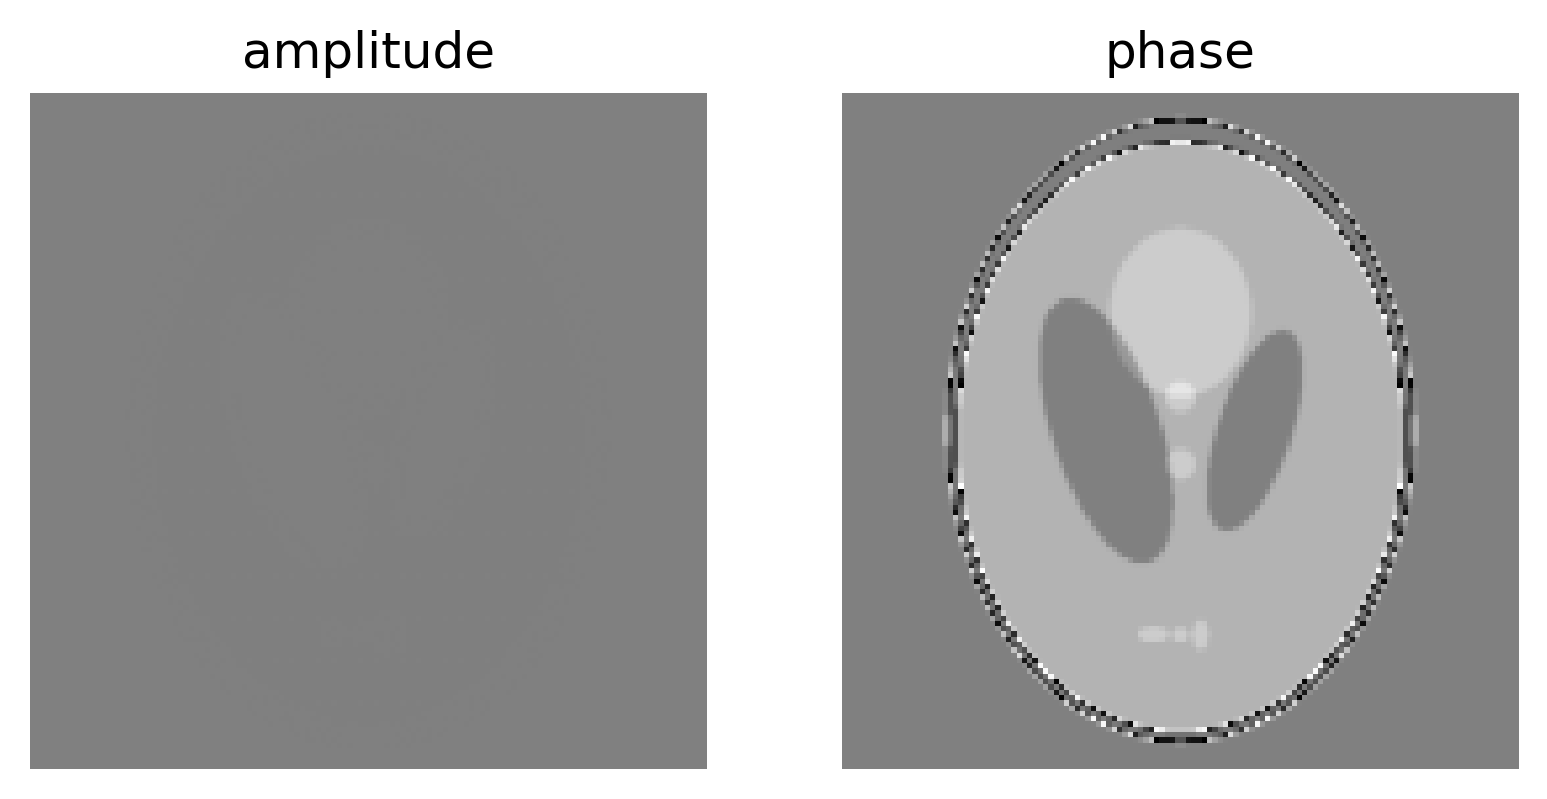

In [5]:
phase = skimage.data.shepp_logan_phantom().astype("float")
phase = skimage.transform.resize(phase, (size, size))
phase = np.expand_dims(phase, axis=(0, -2, -1))
x = np.exp(1j * 2 * np.pi * phase)
# x = cx.ScalarField.create(u=u, dx=1, spectrum=0.532, spectral_density=1.0)
show_amplitude_and_phase(np.abs(x[0, :, :, 0, 0]), np.angle(x[0, :, :, 0, 0]))

In [6]:
linear_jitted = equinox.filter_jit(model.linear)
adjoint_jitted = equinox.filter_jit(model.adjoint)

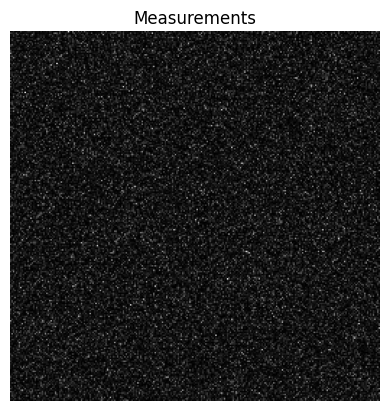

In [7]:
assert jnp.allclose(adjoint_jitted(linear_jitted(x)), x, atol=1e-5), (
    "Adjoint operation does not match original input."
)
y = model.forward(x)
plt.imshow(y[0, :, :, 0, 0], cmap="gray")
plt.axis("off")
plt.title("Measurements")
plt.show()

In [8]:
def spectral_methods(
    y,
    model: StructuredRandomPhaseRetrieval,
    num_iterations: int = 400,
    lambd: float = -5.0,
):
    """
    Perform spectral methods for phase retrieval using the structured random phase retrieval model.

    Arg s:
        y (cx.ScalarField): The observed intensity field.
        model (StructuredRandomPhaseRetrieval): The structured random phase retrieval model.
        num_iterations (int): Number of iterations for the optimization.

    Returns:
        cx.ScalarField: Reconstructed field.
    """
    # x = cx.ScalarField.create(
    #     u=np.exp(1j * 2 * np.pi * np.random.rand(*model.input_shape)),
    #     dx=1,
    #     spectrum=0.532,
    #     spectral_density=1.0,
    # )
    x = jnp.exp(1j * 2 * np.pi * np.random.rand(*model.input_shape))

    y = y / jnp.mean(y)

    amplitude_mask = jnp.maximum(1 - 1 / y, lambd)

    for _ in range(num_iterations):
        # x_new = model.adjoint(
        #     cx.functional.amplitude_change(model.linear(x), amplitude_mask)
        # )
        x_new = adjoint_jitted(amplitude_mask * linear_jitted(x))
        x_new = x_new - 2 * lambd * x
        x_new = x_new / jnp.linalg.norm(x_new.flatten())
        x = x_new
        # print(jnp.linalg.norm(x.u.flatten()))

    return x

In [9]:
x_spec = spectral_methods(model.forward(x), model, num_iterations=400, lambd=-5.0)

In [10]:
def cosine_similarity(x, y):
    """
    Compute the cosine similarity between two complex fields.

    Args:
        x (cx.ScalarField): First complex field.
        y (cx.ScalarField): Second complex field.

    Returns:
        float: Cosine similarity value.
    """
    x = x.flatten()
    y = y.flatten()
    dot_product = jnp.sum(x * jnp.conj(y))
    norm_x = jnp.sqrt(jnp.sum(jnp.abs(x) ** 2))
    norm_y = jnp.sqrt(jnp.sum(jnp.abs(y) ** 2))

    return jnp.abs(dot_product) / (norm_x * norm_y)


def correct_global_phase(x_hat, x, threshold: float = 1e-5, verbose: bool = False):
    assert x_hat.shape == x.shape, "The shapes of the images should be the same."

    n_imgs = x_hat.shape[0]
    n_channels = x_hat.shape[-2]

    for i in range(n_imgs):
        for j in range(n_channels):
            e_minus_phi = (x_hat[i, :, :, j, :].conj() * x[i, :, :, j, :]) / (
                np.abs(x[i, :, :, j, :]) ** 2
            )
            if e_minus_phi.var() < threshold:
                if verbose:
                    print(f"Image {i}, channel {j} has a constant global phase shift.")
            else:
                if verbose:
                    print(f"Image {i}, channel {j} does not have a global phase shift.")
            e_minus_phi = e_minus_phi.mean()
            x_hat.at[i, :, :, j, :].set(x_hat[i, :, :, j, :] * e_minus_phi)

    return x_hat

Cosine similarity: 0.8624758124351501


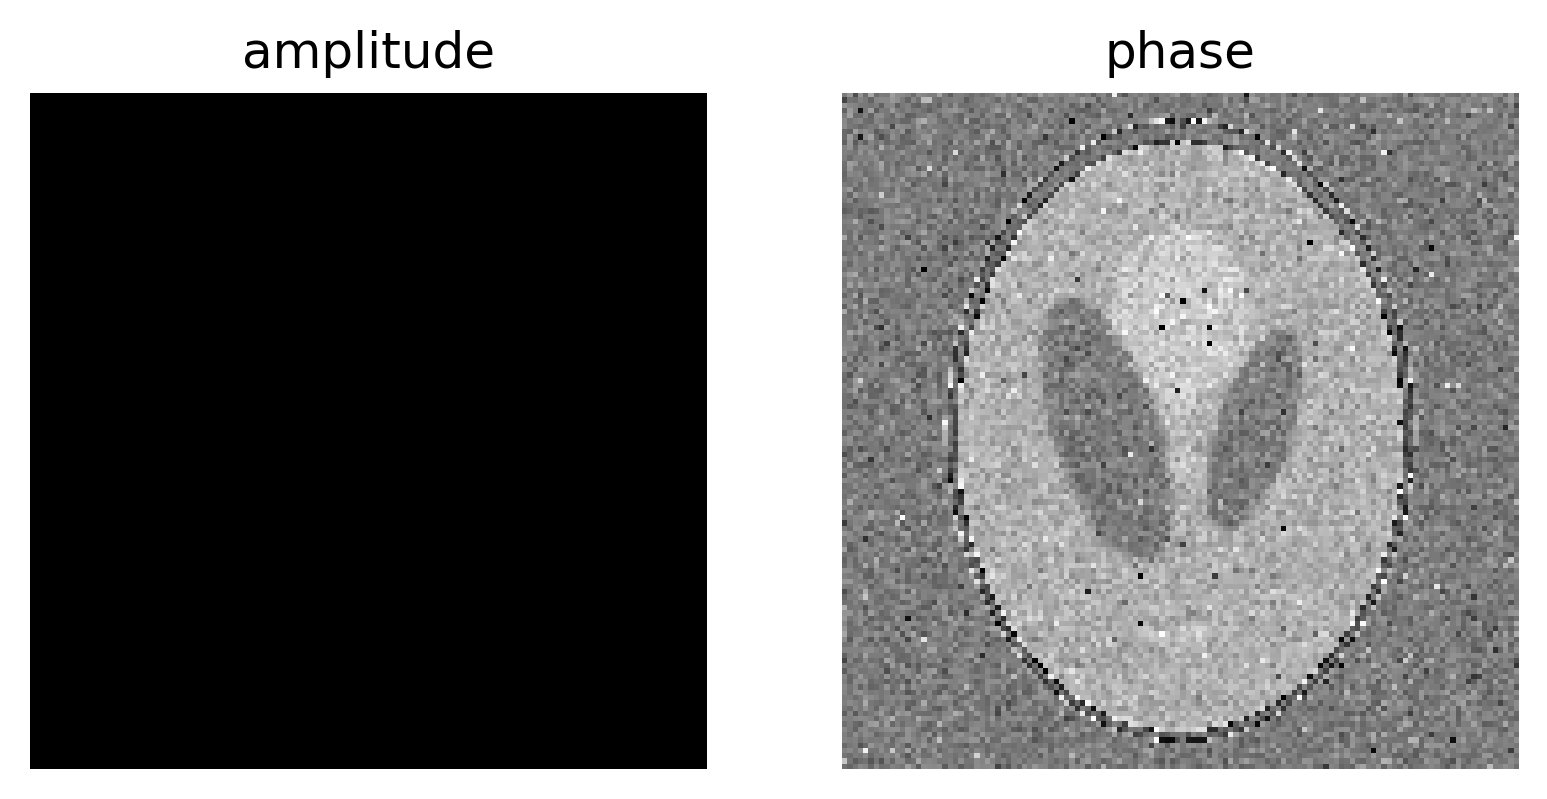

In [11]:
print("Cosine similarity:", cosine_similarity(x_spec, x).item())
x_spec_corrected = correct_global_phase(x_spec, x, threshold=1e-5)
show_amplitude_and_phase(
    np.abs(x_spec_corrected[0, :, :, :, 0]), np.angle(x_spec_corrected[0, :, :, :, 0])
)

In [12]:
parameters = x_spec
optimizer = optax.adam(1e-1)
opt_state = optimizer.init(parameters)

In [13]:
def loss_fn(parameters, measurements):
    simulated = model.forward(parameters)
    return jnp.mean((simulated - measurements) ** 2)

In [14]:
def step(parameters, opt_state, measurements):
    loss, grads = jax.value_and_grad(loss_fn)(parameters, measurements)
    updates, opt_state = optimizer.update(grads.conj(), opt_state)
    parameters = optax.apply_updates(parameters, updates)
    return loss, parameters, opt_state

In [15]:
losses = []
for i in range(200):
    loss, parameters, opt_state = step(parameters, opt_state, y)
    losses.append(np.array(loss))
    print(f"iteration {i + 1} loss = {loss}")

iteration 1 loss = 0.12564820051193237
iteration 2 loss = 0.12263329327106476
iteration 3 loss = 0.11635971814393997
iteration 4 loss = 0.10606858879327774
iteration 5 loss = 0.09232394397258759
iteration 6 loss = 0.07625342160463333
iteration 7 loss = 0.05959375947713852
iteration 8 loss = 0.044624704867601395
iteration 9 loss = 0.03369518369436264
iteration 10 loss = 0.028027193620800972
iteration 11 loss = 0.02655946835875511
iteration 12 loss = 0.02662106603384018
iteration 13 loss = 0.02590392343699932
iteration 14 loss = 0.023563049733638763
iteration 15 loss = 0.020009845495224
iteration 16 loss = 0.01617751456797123
iteration 17 loss = 0.012906192801892757
iteration 18 loss = 0.010648272931575775
iteration 19 loss = 0.009445900097489357
iteration 20 loss = 0.009058176539838314
iteration 21 loss = 0.00912466086447239
iteration 22 loss = 0.009296477772295475
iteration 23 loss = 0.009313344955444336
iteration 24 loss = 0.009033788926899433
iteration 25 loss = 0.008433937095105648


Cosine similarity: 1.0


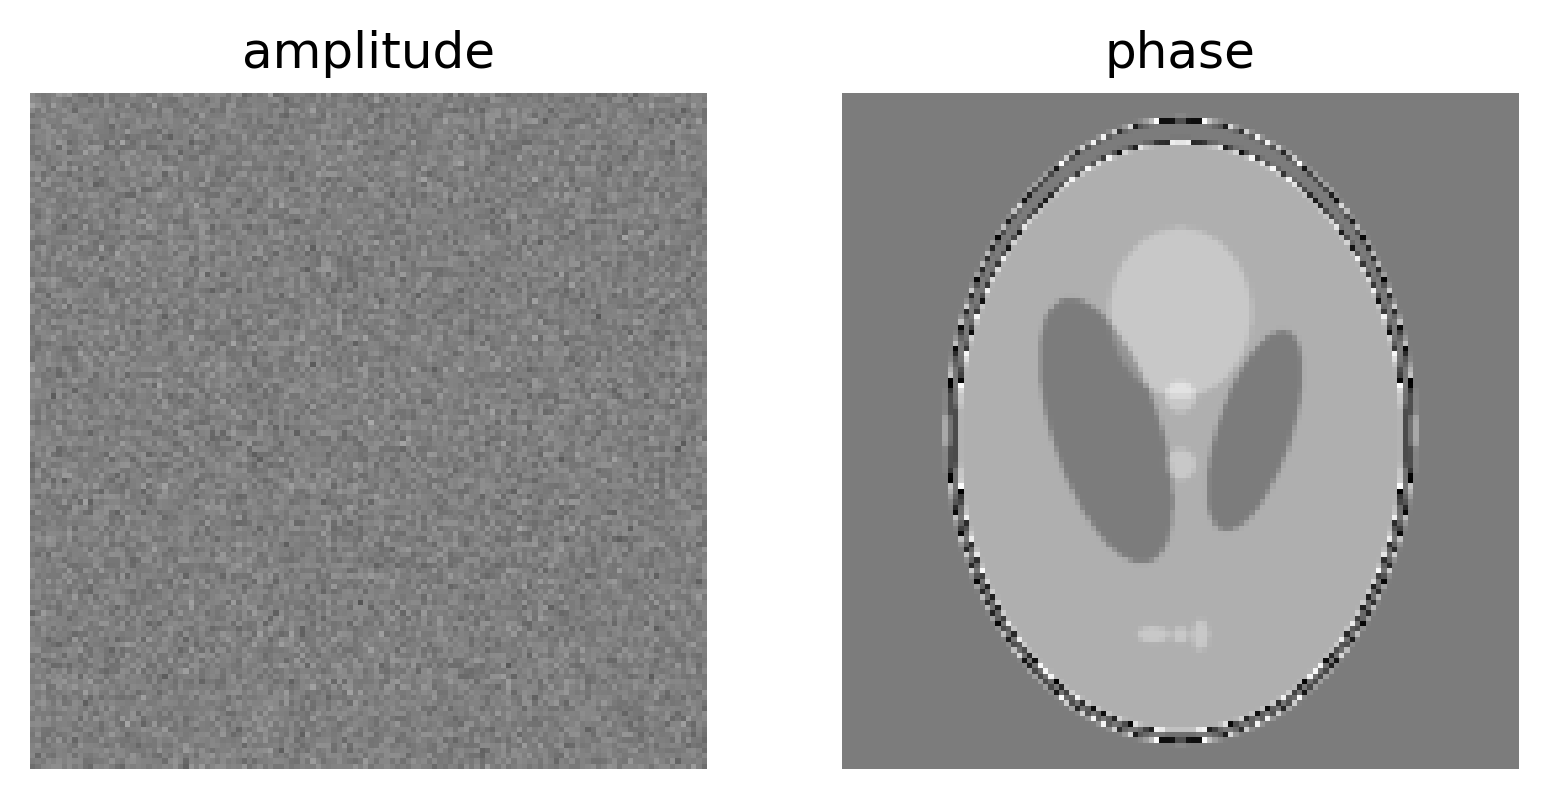

In [16]:
x_gd_spec = parameters
print("Cosine similarity:", cosine_similarity(x_gd_spec, x).item())
show_amplitude_and_phase(
    np.abs(x_gd_spec[0, :, :, :, 0]), np.angle(x_gd_spec[0, :, :, :, 0])
)